# Wall detection

In [66]:
%matplotlib inline

In [125]:
from fastcore.xtras import Path

from fastai.callback.schedule import lr_find

from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, RandomSplitter, Normalize

from fastai.torch_core import tensor

from fastai.vision.widgets import *

import torch
from torchvision.models.resnet import resnet34
import numpy as np
import gc
from pdb import set_trace
import matplotlib.pyplot as plt

In [68]:
path = Path("data")
path.ls()

(#3) [Path('data/walllabels'),Path('data/images'),Path('data/wallmasks')]

In [69]:
path_lbl = path/'walllabels'
path_img = path/'images'

# Data

In [70]:
fnames = get_image_files(path_img)
# fnames[:3]

In [71]:
len(fnames)

122

In [72]:
lbl_names = get_image_files(path_lbl)
# lbl_names[:3]

<AxesSubplot:>

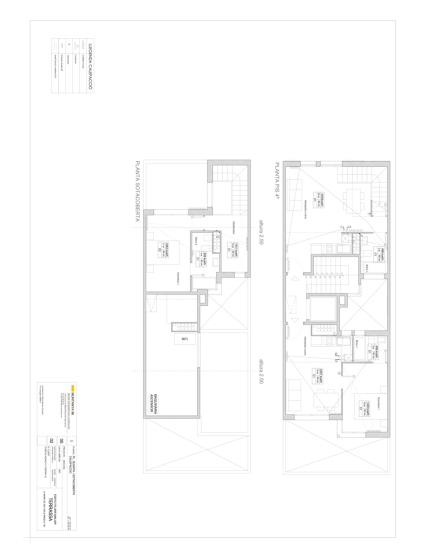

In [73]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(10,10))

In [74]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

<AxesSubplot:>

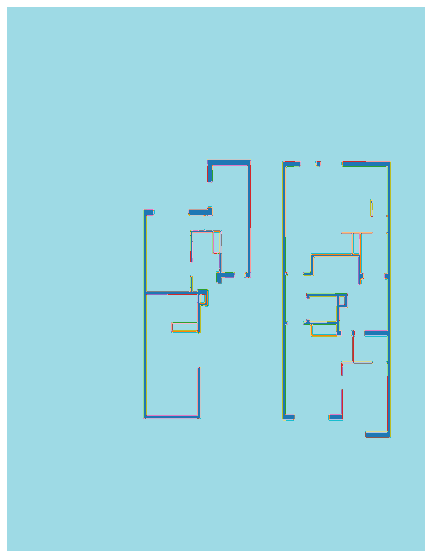

In [75]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [76]:
src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [77]:
codes = ['wall', 'not-wall']; codes

['wall', 'not-wall']

# Datasets

In [78]:
size = src_size//8
print(f"size: {size}")

free = (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / (1024 * 1024)
print(free)
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

size: [708]
1740.921875
using bs=2, have 1740.921875MB of GPU RAM free


In [79]:
smaller = tuple(int(x/16) for x in mask.size); smaller

(354, 461)

In [80]:
datablock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                      get_items=get_image_files,
                      splitter=RandomSplitter(valid_pct=0.1, seed=42),
                      get_y=get_y_fn,
                      batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                      item_tfms=[Resize(smaller)]) 

In [81]:
dls = datablock.dataloaders(path_img, bs=bs)

In [82]:
# src = (SegmentationItemList.from_folder(path_img)
#        .split_by_rand_pct(valid_pct=0.1, seed=1)
#        .label_from_func(get_y_fn, classes=codes))

In [83]:
# data = (src.transform(transforms, size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

In [84]:
# def _plot(i,j,ax):
#     x,y = data.train_ds[1]
#     x.show(ax, y=y)

# plot_multi(_plot, 3, 3, figsize=(8,8))

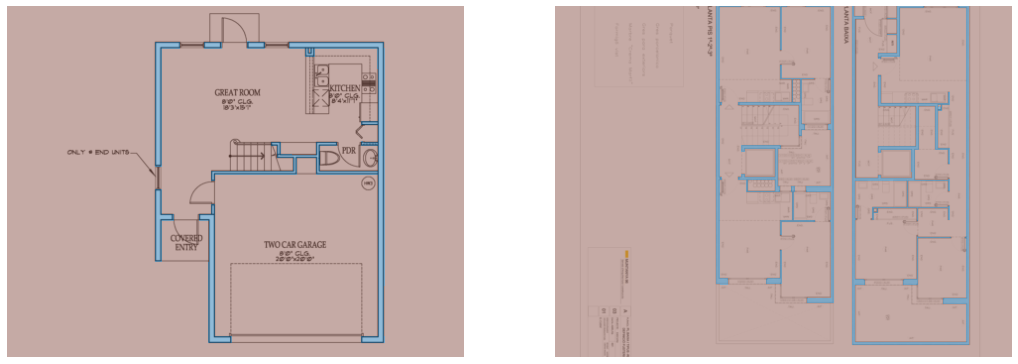

In [137]:
dls.show_batch(figsize=(18,18))

In [86]:
#data.show_batch(3, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [87]:
name2id = {v:k for k,v in enumerate(codes)}
wall_code = name2id['wall']

#def acc_camvid(input, target):
#    target = target.squeeze(1)
#    mask = target != void_code
#    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
def acc_wall(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def precision(input, target):
    # remove the channel dimension (?)
    target = target.squeeze(1)
    input = input.argmax(dim=1)
    mask = input == wall_code
    return (input[mask]==target[mask]).float().mean()

def recall(input, target):
    target = target.squeeze(1)
    mask = target == wall_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
    

In [88]:
# test the metrics
input = tensor([[1,0,0],[1,1,1]],[[0, 1, 1], [0, 0, 0]])
target = tensor([1, 1, 1], [0, 0, 0])
print(precision(input[None], target[None][None])) # add batch dimension to input and batch and channel dimension to target
recall(input[None], target[None][None])

tensor(0.7500)


tensor(1.)

In [89]:
metrics=[acc_wall, precision, recall]
#metrics=acc_wall

In [90]:
wd=1e-2

In [91]:
def cuda_mem_usage():
    max_mem = torch.cuda.max_memory_allocated()
    mem = torch.cuda.memory_allocated()
    print(f"max_mem: {max_mem}, mem: {mem}")

In [92]:
learn = None
gc.collect()
cuda_mem_usage()
print(f"metrics: {metrics}, wd: {wd}")
learn = unet_learner(dls, resnet34, metrics=metrics, wd=wd)
cuda_mem_usage()

max_mem: 9899816960, mem: 4071542272
metrics: [<function acc_wall at 0x7f711322a4c0>, <function precision at 0x7f711322aaf0>, <function recall at 0x7f711322ab80>], wd: 0.01
max_mem: 9899816960, mem: 4071542272


In [93]:
learn.summary()

DynamicUnet (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 64 x 177 x 231  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

max_mem: 9899816960, mem: 4259559424


SuggestedLRs(valley=5.248074739938602e-05)

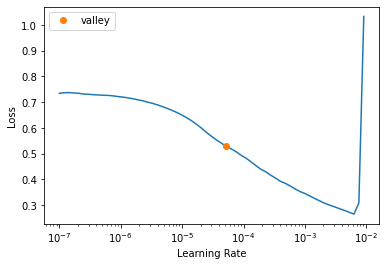

In [94]:
cuda_mem_usage()
learn.lr_find()

In [95]:
lr=5e-5
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

[0, 0.3679339289665222, 0.19000095129013062, 0.9584768414497375, 0.05964154005050659, 0.004888645838946104, '00:10']
[1, 0.18198497593402863, 0.08897820860147476, 0.9787247180938721, 0.8318529725074768, 0.5401454567909241, '00:10']
[2, 0.09903405606746674, 0.05215124785900116, 0.9839628338813782, 0.8994095325469971, 0.6431609392166138, '00:11']
[3, 0.06249219924211502, 0.035247135907411575, 0.9869480133056641, 0.9240773320198059, 0.7072334289550781, '00:10']
[4, 0.043872468173503876, 0.040549423545598984, 0.9861269593238831, 0.9705855846405029, 0.6491281390190125, '00:10']
[5, 0.03487151116132736, 0.02713266760110855, 0.9901778101921082, 0.8923618197441101, 0.8431227207183838, '00:11']
[6, 0.028612442314624786, 0.025263546034693718, 0.9897785186767578, 0.9049401879310608, 0.8135975003242493, '00:10']
[7, 0.025598028674721718, 0.02387205697596073, 0.9904046058654785, 0.9060094356536865, 0.8324972987174988, '00:11']
[8, 0.026071203872561455, 0.024000078439712524, 0.990609884262085, 0.962

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
# learn.destroy()
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
# learn.load('stage-1')

In [123]:
def show_results():
    n_valid = len(dls.valid_ds)
    figsize = (15, n_valid*5)
    fig,axs = plt.subplots(n_valid, 3, figsize=figsize)
    rsz = Resize(smaller)
    for i,(x,y) in enumerate(dls.valid_ds):
        x = rsz(x)
        y = rsz(y)
        x.show(ax=axs[i,0], figsize=(5,5))
        y.show(ax=axs[i,1], figsize=(5,5))
        pred, label, raw = learn.predict(x)        
        #r = recall(pred[None], tensor(y)[None])
        #p = precision(pred[None], tensor(y)[None])
        pred.show(ax=axs[i,2], figsize=(5,5)) #, title=f"recall: {r:.2f}, precision: {p:.2f}")

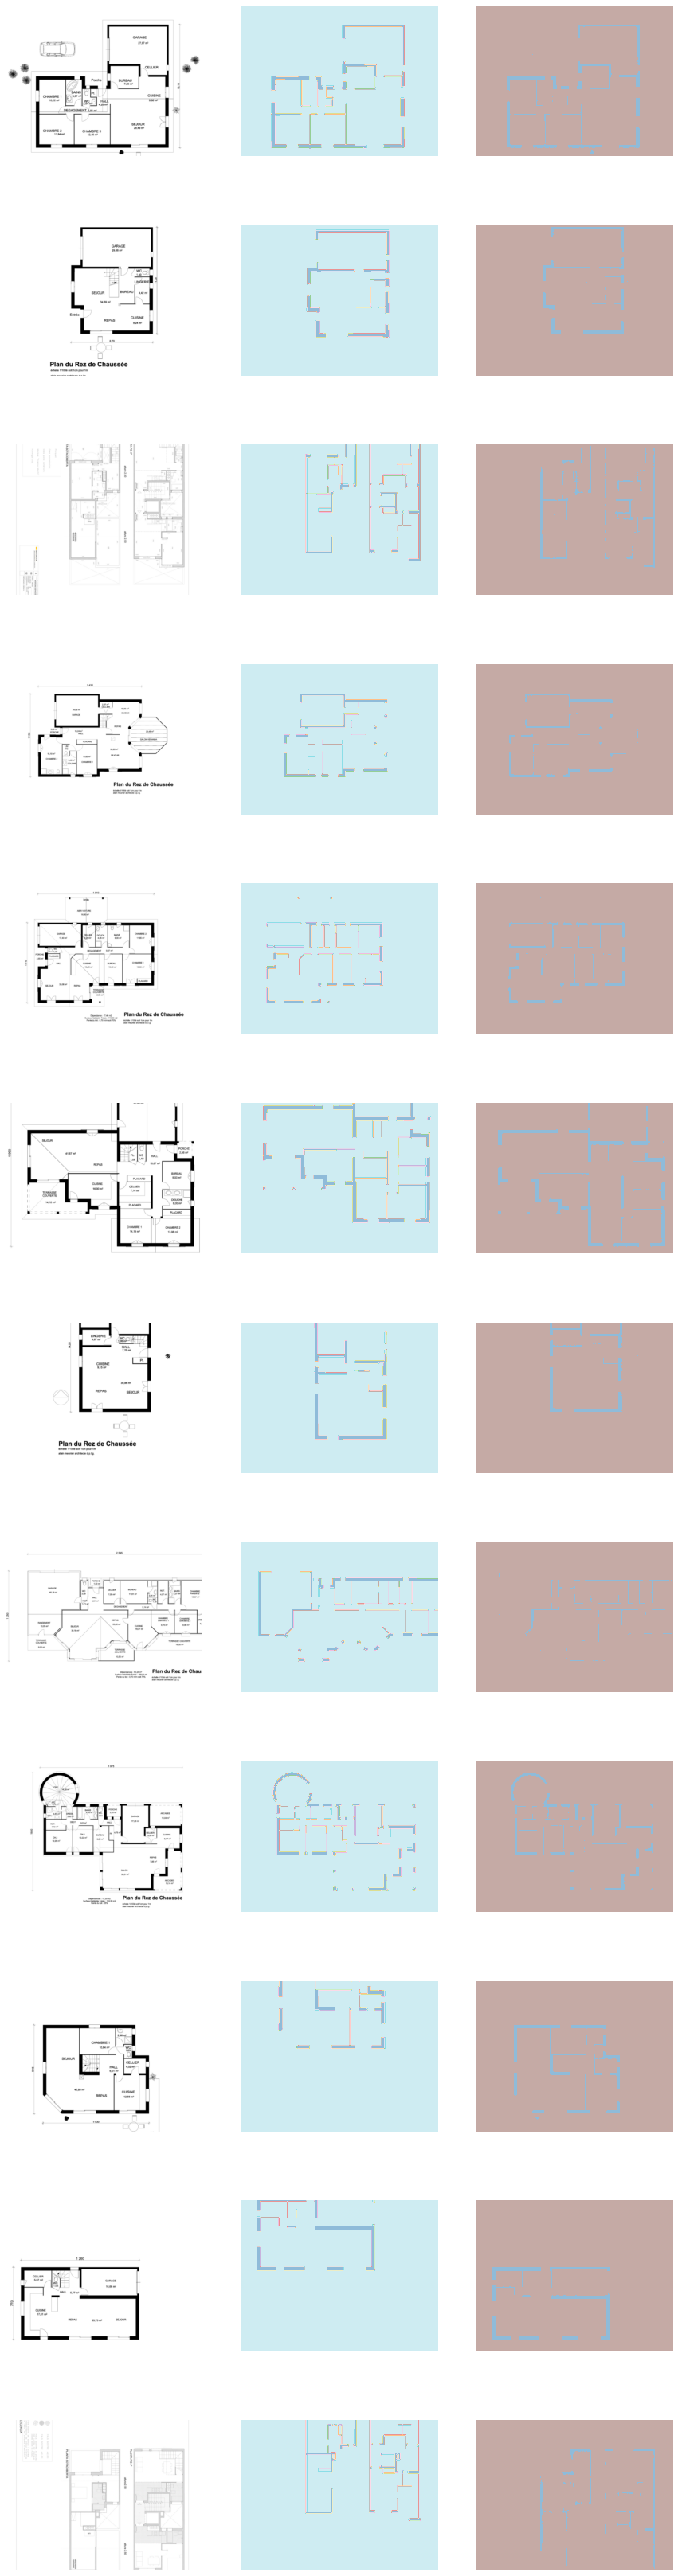

In [138]:
show_results()

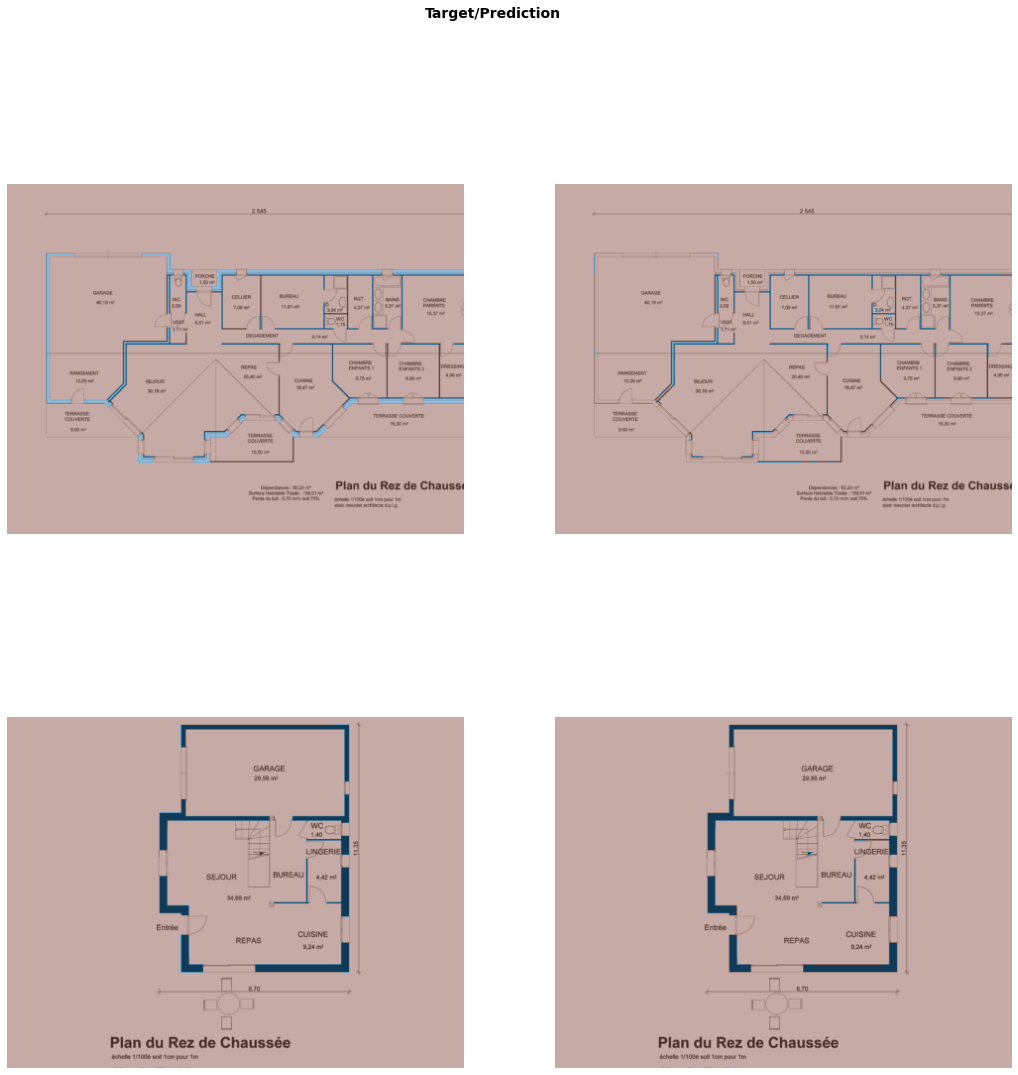

In [139]:
#show_results()
learn.show_results(figsize=(18,18))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/40)

In [ ]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2')

In [ ]:
# learn.destroy()
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()
learn.load('stage-2');

In [ ]:
show_results()

# Inference

In [128]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

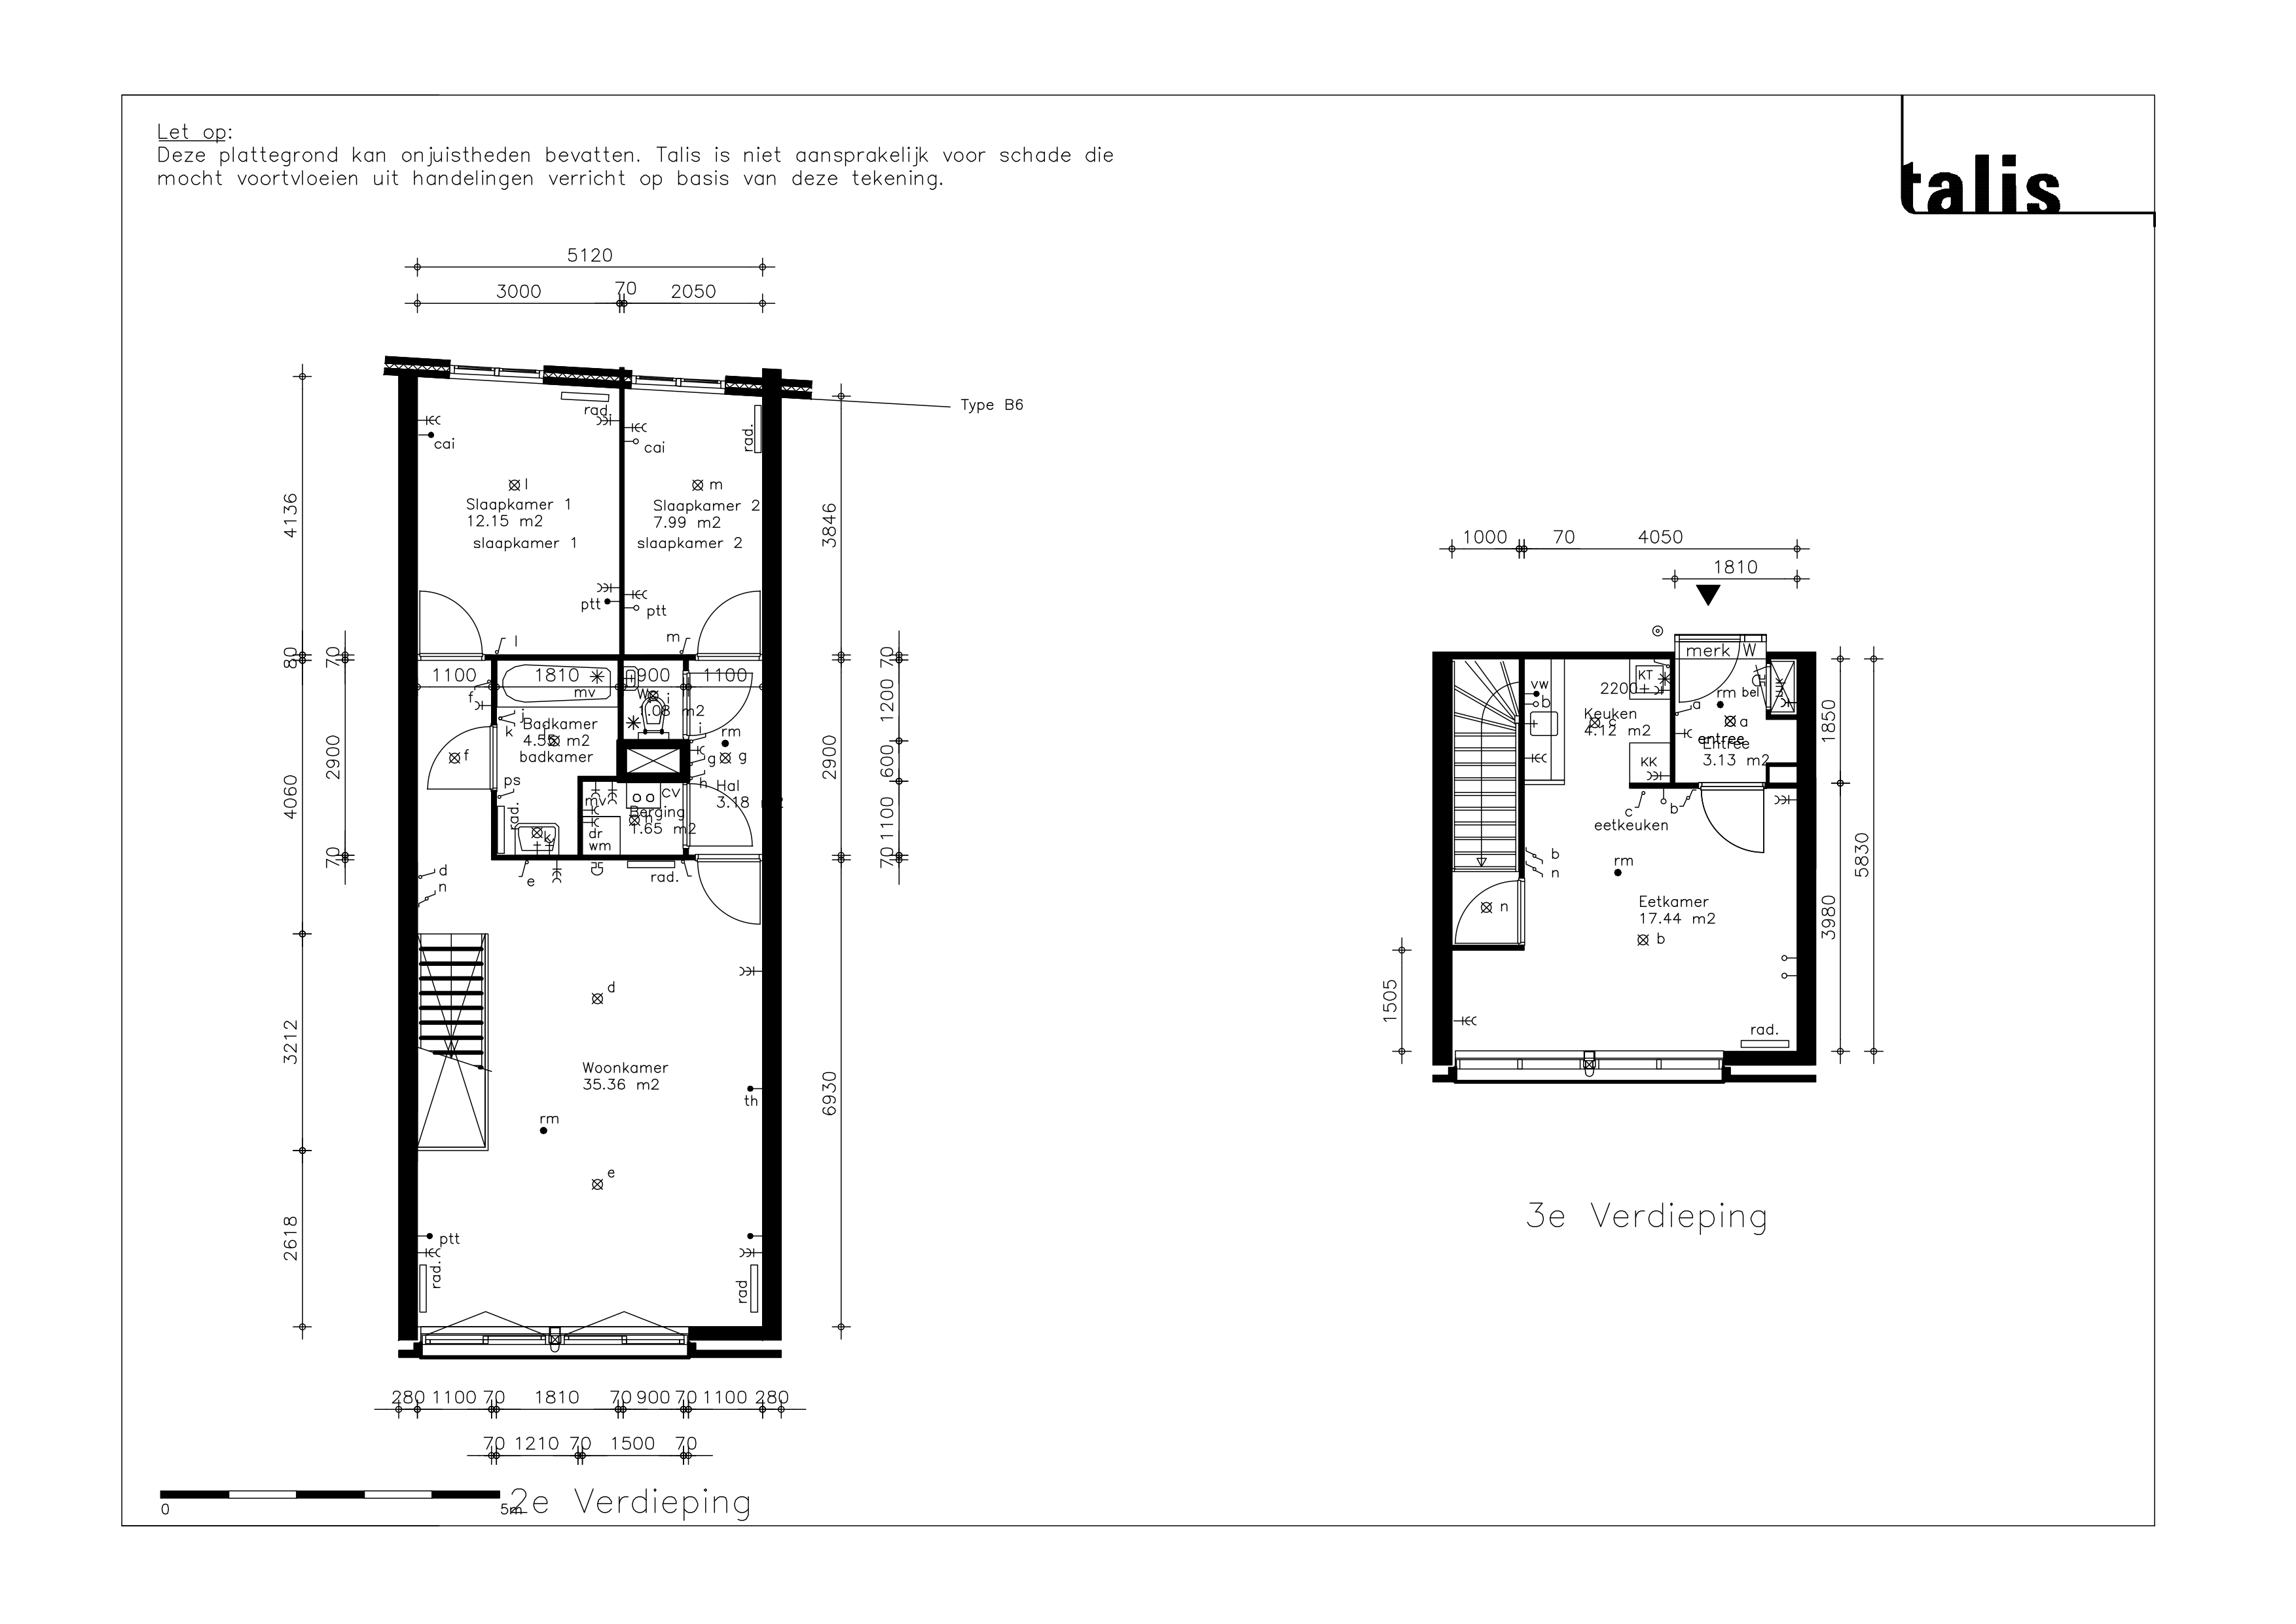

In [140]:
newimg = PILImage.create(btn_upload.data[-1]); newimg

In [141]:
pred, label, raw = learn.predict(newimg)

<AxesSubplot:>

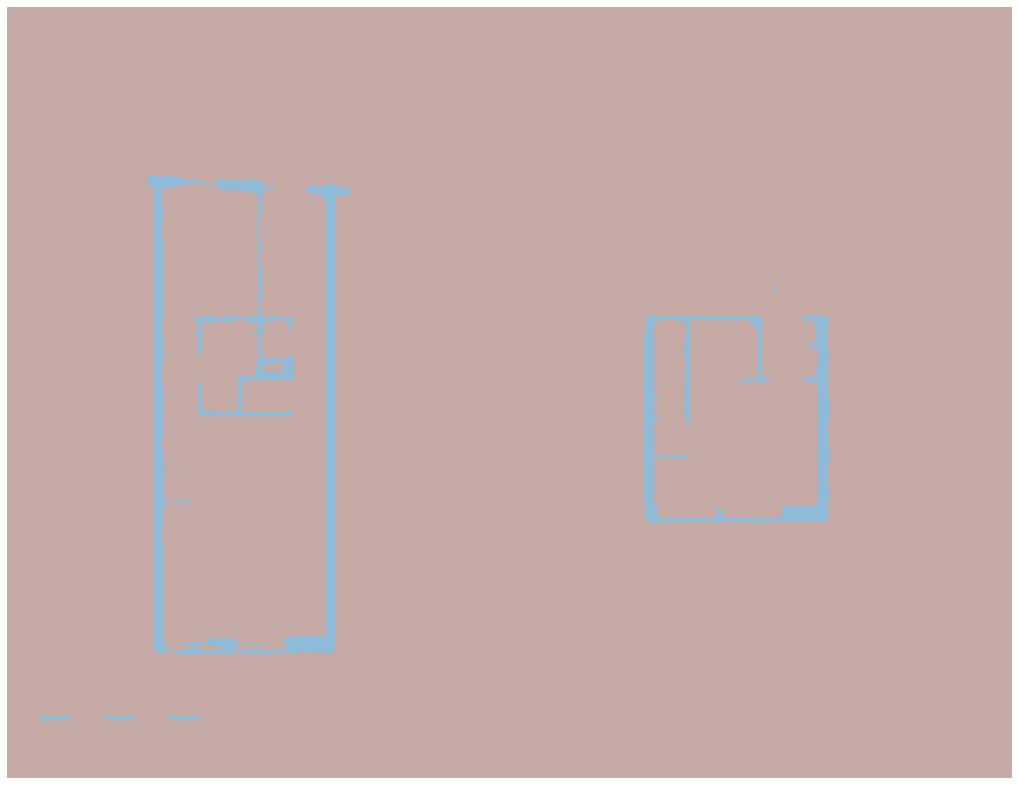

In [142]:
pred.show(figsize=(18,18))

# Manual convolutions

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show(figsize=(10,10))
#data.valid_ds.y[idx]

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
k

In [ ]:
t = data.valid_ds[0][0].data; t.shape

In [ ]:
t[None].shape

In [ ]:
edge = F.conv2d(t[None], k)

In [ ]:
show_image(edge[0], figsize=(10,10));

# Activation visualisation

In [ ]:
learn.load('stage-2')
learn_full = learn.to_fp32()
learn_full.summary()

In [ ]:
m = learn_full.model.eval()

In [ ]:
m[0]

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
xb.shape

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            #preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm, figsize=(3,3)):
    _,ax = plt.subplots(figsize=figsize)
    xb_im.show(ax, figsize)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts, figsize=(10,10))